In [5]:
options(repr.plot.width=8, repr.plot.height=5, jupyter.plot_mimetypes='image/svg+xml')
source('common.r') 
out <- function(obj) write(obj, stdout())

In [2]:
d.old <- data.retwis(where="(name like '%v0.30%' and nclients = 4)")
out("rows: " + nrow(d.old))

ERROR: Error in .local(conn, statement, ...): could not run statement: Table 'claret.retwis' doesn't exist


ERROR: Error in nrow(d.old): object 'd.old' not found


In [3]:
#sql("SELECT threads, nclients, cc_ph, mix, rate, alpha, lambda, scale, txn_retries, txn_count FROM `d.old` WHERE phasing = 'on' and threads = 96")

# New results

In [6]:
d <- data.retwis.socc(where="(name like 'v6%') and shards = 4 and nclients = 4")
out("rows: " + nrow(d))

modes <- c(RW+PH, COMM, COMM+PH, COMB+PH, NOTXN, REDIS)

d <- subset(d, cc_ph %in% modes)
d$cc_ph <- factor(d$cc_ph, levels = rev(modes))

d$x <- d$threads * num(d$nclients)
d$label <- d$threads * num(d$nclients) + "x" + d$rate
d$facet <- with(d, workload) # + "\n" + timeout_scaling)

s <- subset(d, async == 0 
            & (txn_failed < 500 | is.na(txn_failed))
            & total_time > 60 & total_time < 65 
            & (phasing == 'on' | disable_txns == 1 | cc_ph == REDIS)
#             & rate == 5
#             & (name == 'none' | ccmode == 'redis')
           )
out("rows: " + nrow(s))

The following `from` values were not present in `x`: better#0, better#1
The following `from` values were not present in `x`: better#0, better#1
The following `from` values were not present in `x`: rw#0#off#0, simple#0#off#0, simple#1#off#0, better#0#off#0, better#1#off#0, better#0#on#0, better#1#on#0, redis#0#NA#0
The following `from` values were not present in `x`: simple:1


rows: 141
rows: 140


In [7]:
#sql("SELECT DISTINCT ccmode, nclients, threads, mix, rate, alpha, scale FROM d")

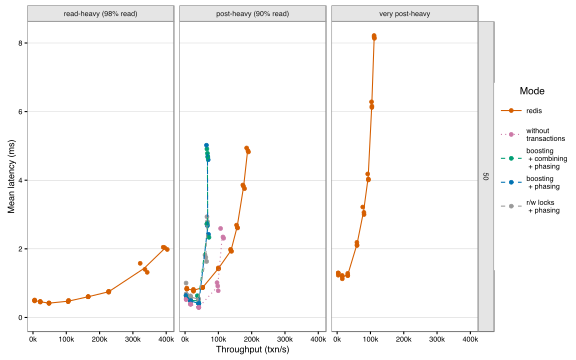

In [8]:
ggplot(s, aes(
    x = throughput,
    y = avg_latency_ms,
    group = cc_ph, fill = cc_ph, color = cc_ph, linetype = cc_ph
))+
  xlab('Throughput (txn/s)')+ylab('Mean latency (ms)')+
  geom_point()+
  # geom_text(aes(label=label), size=1.7)+
  # scale_x_continuous(labels=si.labels())+
  scale_x_continuous(labels = function(x){ x/1000+'k' })+
  # geom_point()+
  geom_mean_path(s, throughput, avg_latency_ms, .(x,facet,cc_ph, rate))+
  expand_limits(y=0)+
#   facet_wrap(~facet, scales="free")+
  facet_grid(rate~facet)+
  # cc_scales()+phasing.linetype()+
  cc_ph_scales()+
  # coord_cartesian(ylim=c(0,100))+
  my_theme() #+theme(legend.position='bottom')

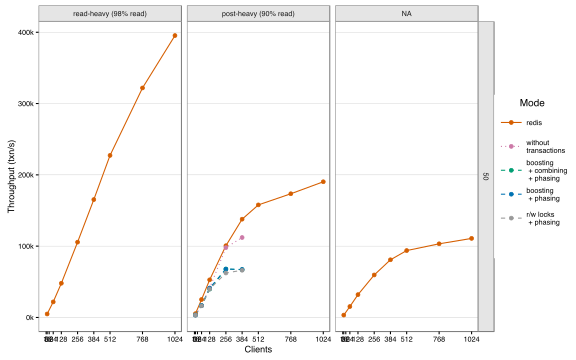

In [17]:
ggplot(subset(s), aes(
    x = x,
    y = throughput,
    group = cc_ph, fill = cc_ph, color = cc_ph, linetype = cc_ph
  ))+
  xlab('Clients')+ylab('Throughput (txn/s)')+
  stat_summary(geom='line', fun.y=mean)+
  stat_summary(geom='point', fun.y=mean)+  
  #scale_x_continuous(trans=log2_trans(), breaks=c(8,16,32,64,128,256,384))+
  scale_x_continuous(breaks=c(8,16,32,64,128,256,384,512,768,1024))+
  scale_y_continuous(labels = function(x){ x/1000+'k' })+
                     #breaks=c(10000,20000,50000,75000,100000,125000,150000,200000,250000,300000))+
  expand_limits(x=0, y=0)+
#   facet_wrap(~facet)+
facet_grid(rate~facet)+
  cc_ph_scales(guide = guide_legend(nrow = 6))+
  my_theme()

In [201]:
s$cc <- factor.remap(s$cc_ph, c('redis'='red', 'without\ntransactions'='no'))

In [203]:
sql("SELECT cc, threads, mix, rate, name, round(avg(throughput)/1000,2) as tput_k, round(avg(avg_latency_ms),2) as latency, round(avg(server_handle_time_mean),2) as handler_us, round(avg(server_handle_time_count),2) as handler_ct, round(avg(server_handle_time_mean)*avg(server_handle_time_count)/1e6/4,2) as handler_time_s FROM s WHERE cc is not null GROUP BY cc, threads, mix, rate, name ORDER BY rate, threads, mix, cc, name")

Warning message:
In `[<-.factor`(`*tmp*`, ri, value = "⋮"): invalid factor level, NA generatedWarning message:
In `[<-.factor`(`*tmp*`, ri, value = "⋮"): invalid factor level, NA generated

,cc,threads,mix,rate,name,tput_k,latency,handler_us,handler_ct,handler_time_s
1,no,4,2read2heavy,5,v2,0.54,0.22,64,95580,1.53
2,no,4,2read2heavy,5,v2.1,0.54,0.22,62.5,95614,1.49
3,red,4,2read2heavy,5,v2,0.47,0.15,NA,NA,NA
4,no,4,geom_repost,5,v2,0.53,0.46,63.25,214214,3.39
5,no,4,geom_repost,5,v2.1,0.54,0.45,59.5,226986,3.38
6,red,4,geom_repost,5,v2,0.46,0.28,NA,NA,NA
7,no,16,2read2heavy,5,v2,2.26,0.2,56,406354.67,5.69
8,no,16,2read2heavy,5,v2.1,2.26,0.19,51,403176,5.14
9,red,16,2read2heavy,5,v2,1.91,0.15,NA,NA,NA
10,no,16,geom_repost,5,v2,2.48,0.42,53.67,1025420,13.76
